In [1]:
from PIL import Image
import pickle
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline ,StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 512
border = 100
background_color = 255

# Starting image is a square on white bg
booth = np.ones((img_size, img_size,3))*background_color
booth[border:img_size-border,border:img_size-border,:] = 0
booth = Image.fromarray(booth.astype(np.uint8()))

mask = np.zeros((img_size,img_size,3))
mask[border:img_size-border,border:img_size-border,:] = 255
mask = Image.fromarray(mask.astype(np.uint8()))

In [3]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

prompt = "a yellow pot"
prompt_details = ", full body centered camera view, blender render, high resolution, standard light, no reflections"

generated_image = [pipe(prompt=prompt + prompt_details, image=booth, mask_image=mask).images[0] for i in range(4)]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\ricca\anaconda3\envs\pytorch_deeplearning\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [4]:
'''
# GLIDE 3B has been used // StableDiffusion 2 trained on LAION-5B
pipe = StableDiffusionPipeline.from_pretrained(
    #"CompVis/stable-diffusion-v1-4",
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

# Low GPU ram mode (but slower) 
pipe.enable_attention_slicing()

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to('cuda')

prompt = "a pot"
prompt_details = ", full body centered camera view, blender render, high resolution, standard light, no reflections"
generated_image = pipe(prompt + prompt_details).images[0]

'''

'\n# GLIDE 3B has been used // StableDiffusion 2 trained on LAION-5B\npipe = StableDiffusionPipeline.from_pretrained(\n    #"CompVis/stable-diffusion-v1-4",\n    "stabilityai/stable-diffusion-2-inpainting",\n    torch_dtype=torch.float16,\n).to(device)\n\n# Low GPU ram mode (but slower) \npipe.enable_attention_slicing()\n\n# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead\npipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)\npipe = pipe.to(\'cuda\')\n\nprompt = "a pot"\nprompt_details = ", full body centered camera view, blender render, high resolution, standard light, no reflections"\ngenerated_image = pipe(prompt + prompt_details).images[0]\n\n'

In [5]:
# lightweight the ram

PILtoTensor = transforms.ToTensor()
torch.cuda.empty_cache()
del pipe
import gc
gc.collect()



81

In [6]:
'''

import matplotlib.image as mpimg
generated_image = mpimg.imread('./car.jpg')
plt.figure(figsize=(8,8))
plt.imshow(generated_image)

'''

generated_image

[<PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>]

In [7]:
from PIL import Image
import pickle
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline ,StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# generaate the model

base_name = 'base300M' # base40M, use base300M or base1B for better results
n_points = 1024
final_n_points = 4096
MODEL_CONFIGS[base_name]["n_ctx"] = n_points
MODEL_CONFIGS["upsample"]["n_ctx"] = final_n_points - n_points

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [8]:

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[n_points, final_n_points - n_points], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)
#,generated_image

In [ ]:
# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=generated_image))):
    samples = x

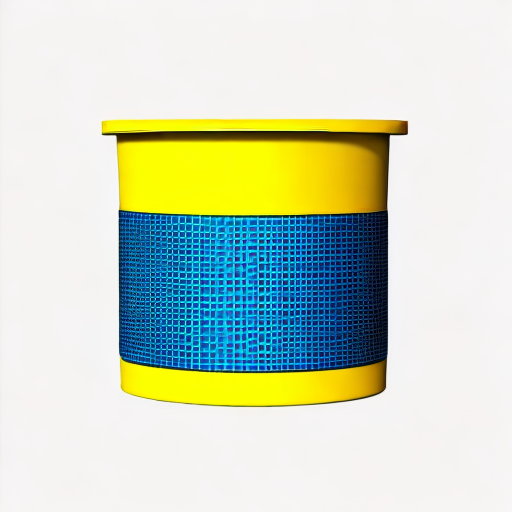

In [10]:
generated_image[3]

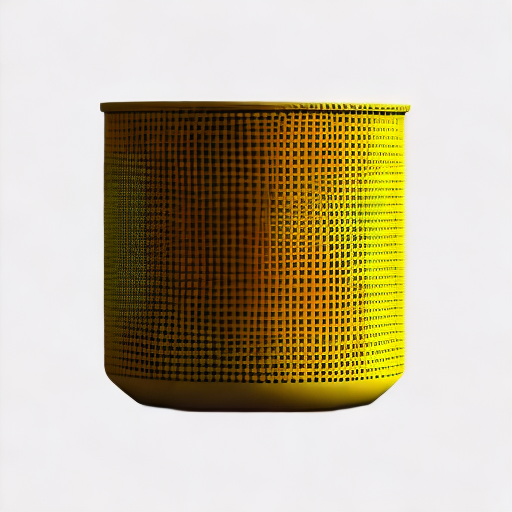

In [14]:
generated_image[0]

creating SDF model...
loading SDF model...


  0%|          | 0/8 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

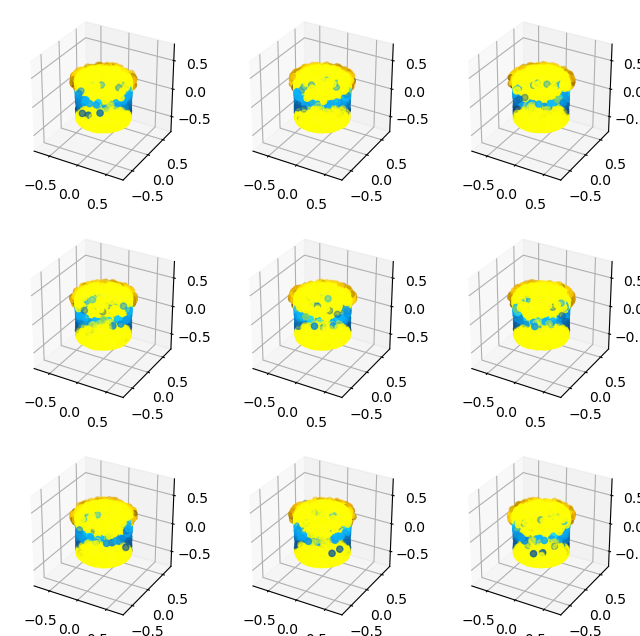

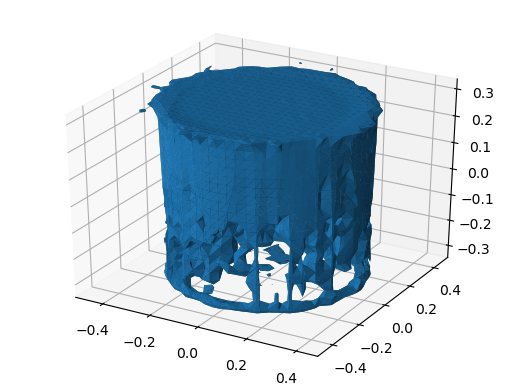

In [11]:
# generate the mesh

pc = sampler.output_to_point_clouds(samples)[0]
plt.figure(figsize=(8,8))
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))


from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import skimage.measure as measure
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

# Signed distance field model
print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=final_n_points,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(mesh.verts[:, 0], mesh.verts[:,1], triangles=mesh.faces, Z=mesh.verts[:,2]) 
plt.show()